# Armor U-Net Training on Google Colab

This notebook installs the project dependencies, syncs the repository, configures paths/hyperparameters, and runs `train_armor_detector` using the same codebase as the main repo. Adjust the form fields as needed for your dataset location or run length before executing the training cell.

In [1]:
# Check GPU availability (optional but recommended)
!nvidia-smi

Sun Oct 26 14:20:34 2025       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 550.54.15              Driver Version: 550.54.15      CUDA Version: 12.4     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  Tesla T4                       Off |   00000000:00:04.0 Off |                    0 |
| N/A   60C    P8             11W /   70W |       0MiB /  15360MiB |      0%      Default |
|                                         |                        |                  N/A |
+-----------------------------------------+-----

In [2]:
%%capture
# Install the Python dependencies needed by the project
!pip install --quiet pytorch-lightning>=2.2 albumentations>=1.3 wandb>=0.16 pillow matplotlib

In [3]:
#@title (Optional) Mount Google Drive
USE_DRIVE = False  # @param {type:"boolean"}
if USE_DRIVE:
    from google.colab import drive
    drive.mount('/content/drive')

In [4]:
#@title Clone or update the repository
import os, subprocess, sys, pathlib
REPO_URL = "https://github.com/GoldenPandaMRW/torch-lightning-with-ray.git"  # @param {type:"string"}
TARGET_DIR = "/content/torch-lightning-with-ray"  # @param {type:"string"}
BRANCH_NAME = "main"  # @param {type:"string"}
target_path = pathlib.Path(TARGET_DIR)
if not target_path.exists():
    subprocess.run(["git", "clone", REPO_URL, str(target_path)], check=True)
else:
    subprocess.run(["git", "-C", str(target_path), "fetch"], check=True)
    subprocess.run(["git", "-C", str(target_path), "reset", "--hard", "origin/" + BRANCH_NAME], check=True)
subprocess.run(["git", "-C", str(target_path), "checkout", BRANCH_NAME], check=True)
subprocess.run(["git", "-C", str(target_path), "pull", "origin", BRANCH_NAME], check=True)
os.chdir(target_path)
if str(target_path) not in sys.path:
    sys.path.insert(0, str(target_path))
print(f'Working directory: {target_path} (branch: {BRANCH_NAME})')

Working directory: /content/torch-lightning-with-ray (branch: main)


In [5]:
!pip install roboflow

from roboflow import Roboflow
rf = Roboflow(api_key="API-KEY")
project = rf.workspace("crowd-analysis-dataset").project("dataset_robomaster-jlvqw")
version = project.version(1)
dataset = version.download("coco")

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 89.9/89.9 kB 4.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 66.8/66.8 kB 5.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 49.9/49.9 MB 21.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.4/1.4 MB 93.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.2/4.2 MB 130.7 MB/s eta 0:00:00
  Attempting uninstall: opencv-python-headless
    Found existing installation: opencv-python-headless 4.12.0.88
    Uninstalling opencv-python-headless-4.12.0.88:
      Successfully uninstalled opencv-python-headless-4.12.0.88
  Attempting uninstall: idna
    Found existing installation: idna 3.11
    Uninstalling idna-3.11:
      Successfully uninstalled idna-3.11
loading Roboflow workspace...
loading Roboflow project...



Extracting Dataset Version Zip to Dataset_Robomaster-1 in coco:: 100%|██████████| 508/508 [00:00<00:00, 8802.94it/s]


In [18]:
#@title Configure data/log locations and key hyperparameters
import os, pathlib
DATA_ROOT = "/content/torch-lightning-with-ray/Dataset_Robomaster-1"  # @param {type:"string"}
CHECKPOINT_DIR = "/content/checkpoints"  # @param {type:"string"}
LOG_DIR = "/content/logs"  # @param {type:"string"}
BATCH_SIZE = 4  # @param {type:"integer"}
MAX_EPOCHS = 5  # @param {type:"integer"}
BASE_CHANNELS = 32  # @param {type:"integer"}
LEARNING_RATE = 1e-4  # @param {type:"number"}
for path in (DATA_ROOT, CHECKPOINT_DIR, LOG_DIR):
    pathlib.Path(path).mkdir(parents=True, exist_ok=True)
os.environ['DATA_ROOT'] = DATA_ROOT
os.environ['CHECKPOINT_DIR'] = CHECKPOINT_DIR
os.environ['LOG_DIR'] = LOG_DIR
print(f'DATA_ROOT: {DATA_ROOT}')
print(f'CHECKPOINT_DIR: {CHECKPOINT_DIR}')
print(f'LOG_DIR: {LOG_DIR}')

DATA_ROOT: /content/torch-lightning-with-ray/Dataset_Robomaster-1
CHECKPOINT_DIR: /content/checkpoints
LOG_DIR: /content/logs


In [19]:
#@title Authenticate with Weights & Biases
import wandb
wandb.login()
wandb.init(project="armor_unet")

In [20]:
#@title Run training
from train import train_armor_detector
model, trainer, datamodule = train_armor_detector(
    data_root=DATA_ROOT,
    batch_size=BATCH_SIZE,
    max_epochs=MAX_EPOCHS,
    learning_rate=LEARNING_RATE,
    base_channels=BASE_CHANNELS,
    checkpoint_dir=CHECKPOINT_DIR,
    log_dir=LOG_DIR,
)

INFO:lightning_fabric.utilities.seed:Seed set to 42
/usr/local/lib/python3.12/dist-packages/pytorch_lightning/loggers/wandb.py:397: There is a wandb run already in progress and newly created instances of `WandbLogger` will reuse this run. If this is not desired, call `wandb.finish()` before instantiating `WandbLogger`.
wandb: logging graph, to disable use `wandb.watch(log_graph=False)`
INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
/usr/local/lib/python3.12/dist-packages/pytorch_lightning/callbacks/model_checkpoint.py:751: Checkpoint directory /content/checkpoints exists and is not empty.
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:pytorch_lightning.callbacks.model_summary:
  | Name  | Type      | Params | Mode  | In sizes         | Out sizes      

ARMOR PLATE DETECTION - PyTorch Lightning

Initializing data module...
Creating model...
Model parameters: 1,928,417

Starting training...


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.callbacks.early_stopping:Metric val_dice improved. New best score: 0.741
INFO:pytorch_lightning.utilities.rank_zero:Epoch 0, global step 88: 'val_dice' reached 0.74097 (best 0.74097), saving model to '/content/checkpoints/armor-unet-epoch=00-val_dice=0.7410.ckpt' as top 1


Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.callbacks.early_stopping:Metric val_dice improved by 0.045 >= min_delta = 0.0. New best score: 0.786
INFO:pytorch_lightning.utilities.rank_zero:Epoch 1, global step 176: 'val_dice' reached 0.78627 (best 0.78627), saving model to '/content/checkpoints/armor-unet-epoch=01-val_dice=0.7863.ckpt' as top 1


Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:Epoch 2, global step 264: 'val_dice' was not in top 1


Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.callbacks.early_stopping:Metric val_dice improved by 0.007 >= min_delta = 0.0. New best score: 0.793
INFO:pytorch_lightning.utilities.rank_zero:Epoch 3, global step 352: 'val_dice' reached 0.79290 (best 0.79290), saving model to '/content/checkpoints/armor-unet-epoch=03-val_dice=0.7929.ckpt' as top 1


Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.callbacks.early_stopping:Metric val_dice improved by 0.017 >= min_delta = 0.0. New best score: 0.810
INFO:pytorch_lightning.utilities.rank_zero:Epoch 4, global step 440: 'val_dice' reached 0.81033 (best 0.81033), saving model to '/content/checkpoints/armor-unet-epoch=04-val_dice=0.8103.ckpt' as top 1
INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=5` reached.
INFO:pytorch_lightning.utilities.rank_zero:Restoring states from the checkpoint path at /content/checkpoints/armor-unet-epoch=04-val_dice=0.8103.ckpt
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:pytorch_lightning.utilities.rank_zero:Loaded model weights from the checkpoint at /content/checkpoints/armor-unet-epoch=04-val_dice=0.8103.ckpt



Testing best model...


Testing: |          | 0/? [00:00<?, ?it/s]

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│         test_dice         │    0.8225956559181213     │
│         test_loss         │    0.30746692419052124    │
└───────────────────────────┴───────────────────────────┘


Training complete!
Best model saved to: /content/checkpoints/armor-unet-epoch=04-val_dice=0.8103.ckpt
Best validation Dice: 0.8103

Track the run in Weights & Biases:
  https://wandb.ai/micahr-virginia-tech/armor_unet/runs/reh4nh7x


epoch,▁▁▂▂▄▄▅▅▇▇█
lr-Adam,▁▁▁▁▁
test_dice,▁
test_loss,▁
train_dice,▁▆▇██
train_loss,█▄▃▂▁
trainer/global_step,▁▂▂▂▄▄▄▅▅▅▇▇▇███
val_dice,▁▆▅▆█
val_loss,█▆▄▃▁
epoch,5
lr-Adam,0.0001


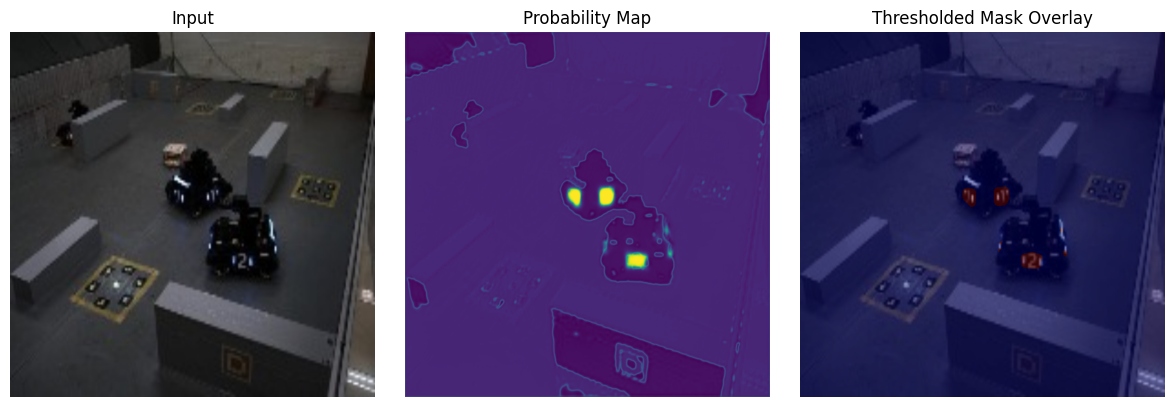

In [27]:
import os
import torch
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt
import torch.nn.functional as F

from armor_unet.lit_module import ArmorUNet


CHECKPOINT_PATH = "/content/checkpoints/armor-unet-epoch=04-val_dice=0.8103.ckpt"
IMAGE_PATH = "/content/images/thumb2.jpg"
DEVICE = "cuda" if torch.cuda.is_available() else "cpu"
THRESHOLD = 0.5
TARGET_SIZE = (640, 640)  # set to None to keep original size

def load_model(ckpt_path: str, device: str) -> ArmorUNet:
    model = ArmorUNet.load_from_checkpoint(ckpt_path)
    model.eval().to(device)
    return model

def preprocess_image(image_path: str, target_size=None):
    image = Image.open(image_path).convert("RGB")
    if target_size is not None:
        image = image.resize(target_size, Image.BILINEAR)

    arr = np.asarray(image).astype("float32") / 255.0
    mean = np.array([0.485, 0.456, 0.406], dtype="float32")
    std = np.array([0.229, 0.224, 0.225], dtype="float32")
    arr = (arr - mean) / std

    tensor = torch.from_numpy(arr).permute(2, 0, 1).unsqueeze(0)
    return image, tensor

def pad_to_multiple(tensor: torch.Tensor, multiple: int = 8):
    _, _, h, w = tensor.shape
    pad_h = (multiple - h % multiple) % multiple
    pad_w = (multiple - w % multiple) % multiple
    padded = F.pad(tensor, (0, pad_w, 0, pad_h))
    return padded, pad_h, pad_w

def infer_mask(model: ArmorUNet, tensor: torch.Tensor, threshold: float, device: str):
    tensor = tensor.to(device)
    tensor, pad_h, pad_w = pad_to_multiple(tensor)

    with torch.no_grad():
        logits = model(tensor)
        probs = torch.sigmoid(logits)

    probs = probs[..., : probs.shape[-2] - pad_h or None, : probs.shape[-1] - pad_w or None]
    prob_map = probs[0, 0].cpu().numpy()
    mask = (prob_map > threshold).astype("float32")
    return prob_map, mask

def plot_result(image: Image.Image, prob_map: np.ndarray, mask: np.ndarray):
    plt.figure(figsize=(12, 4))
    plt.subplot(1, 3, 1)
    plt.imshow(image)
    plt.title("Input")
    plt.axis("off")

    plt.subplot(1, 3, 2)
    plt.imshow(prob_map, cmap="viridis")
    plt.title("Probability Map")
    plt.axis("off")

    plt.subplot(1, 3, 3)
    plt.imshow(image)
    plt.imshow(mask, cmap="jet", alpha=0.4)
    plt.title("Thresholded Mask Overlay")
    plt.axis("off")

    plt.tight_layout()
    plt.show()

def main():
    if not os.path.exists(CHECKPOINT_PATH):
        raise FileNotFoundError(f"Checkpoint not found: {CHECKPOINT_PATH}")
    if not os.path.exists(IMAGE_PATH):
        raise FileNotFoundError(f"Image not found: {IMAGE_PATH}")

    model = load_model(CHECKPOINT_PATH, DEVICE)
    image, tensor = preprocess_image(IMAGE_PATH, TARGET_SIZE)
    prob_map, mask = infer_mask(model, tensor, THRESHOLD, DEVICE)
    plot_result(image, prob_map, mask)

    # Save the probability map and binary mask
    outputs_dir = "outputs"
    os.makedirs(outputs_dir, exist_ok=True)

    prob_img = Image.fromarray((prob_map * 255).astype("uint8"))
    prob_img.save(os.path.join(outputs_dir, "prob_map.png"))

    mask_img = Image.fromarray((mask * 255).astype("uint8"))
    mask_img.save(os.path.join(outputs_dir, "mask_binary.png"))


if __name__ == "__main__":
    main()